c:\Users\FamiliaNatelloMedina\Documents\UNLu\armado-tesina\codigo\datasets\config_datasets.py:56: SyntaxWarning: invalid escape sequence '\s'
  "sep": "\s+",



📈 Histogramas IF: SHUTTLE


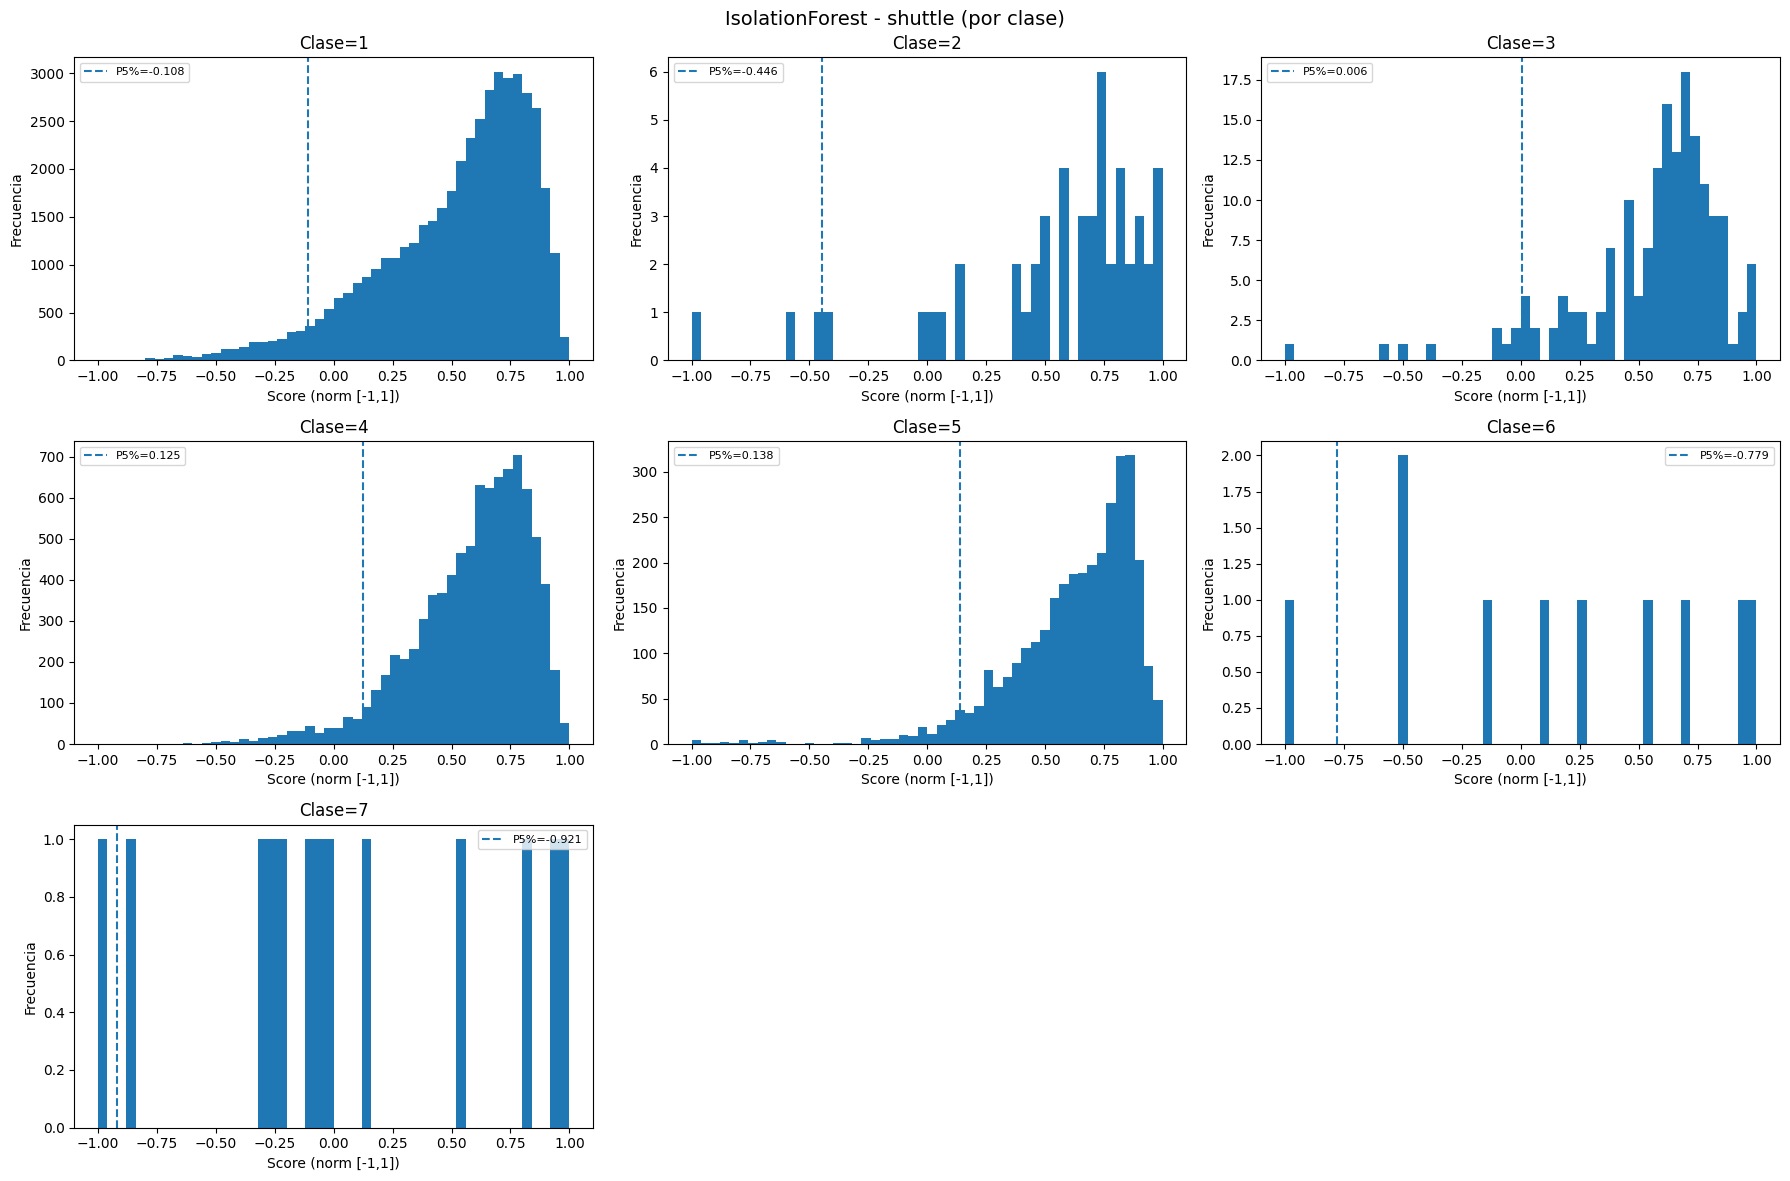


📈 Histogramas IF: WDBC


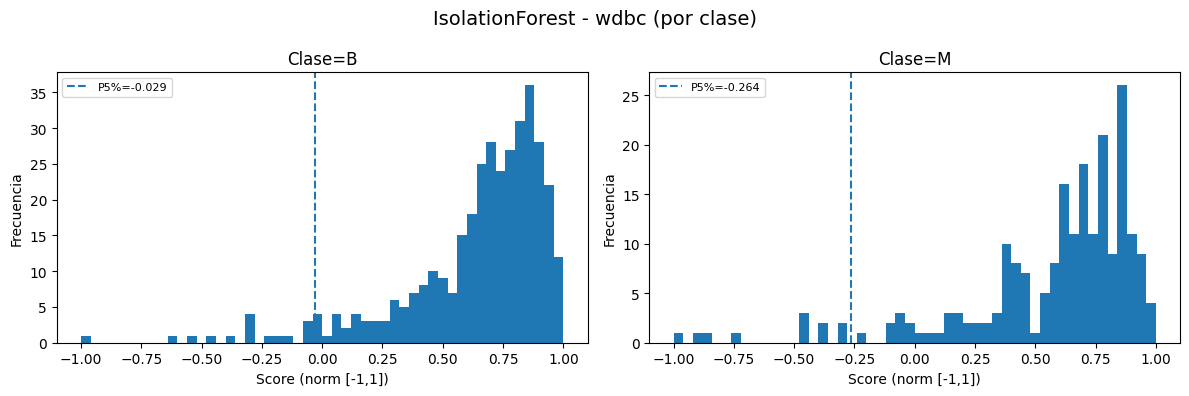


📈 Histogramas IF: GLASS


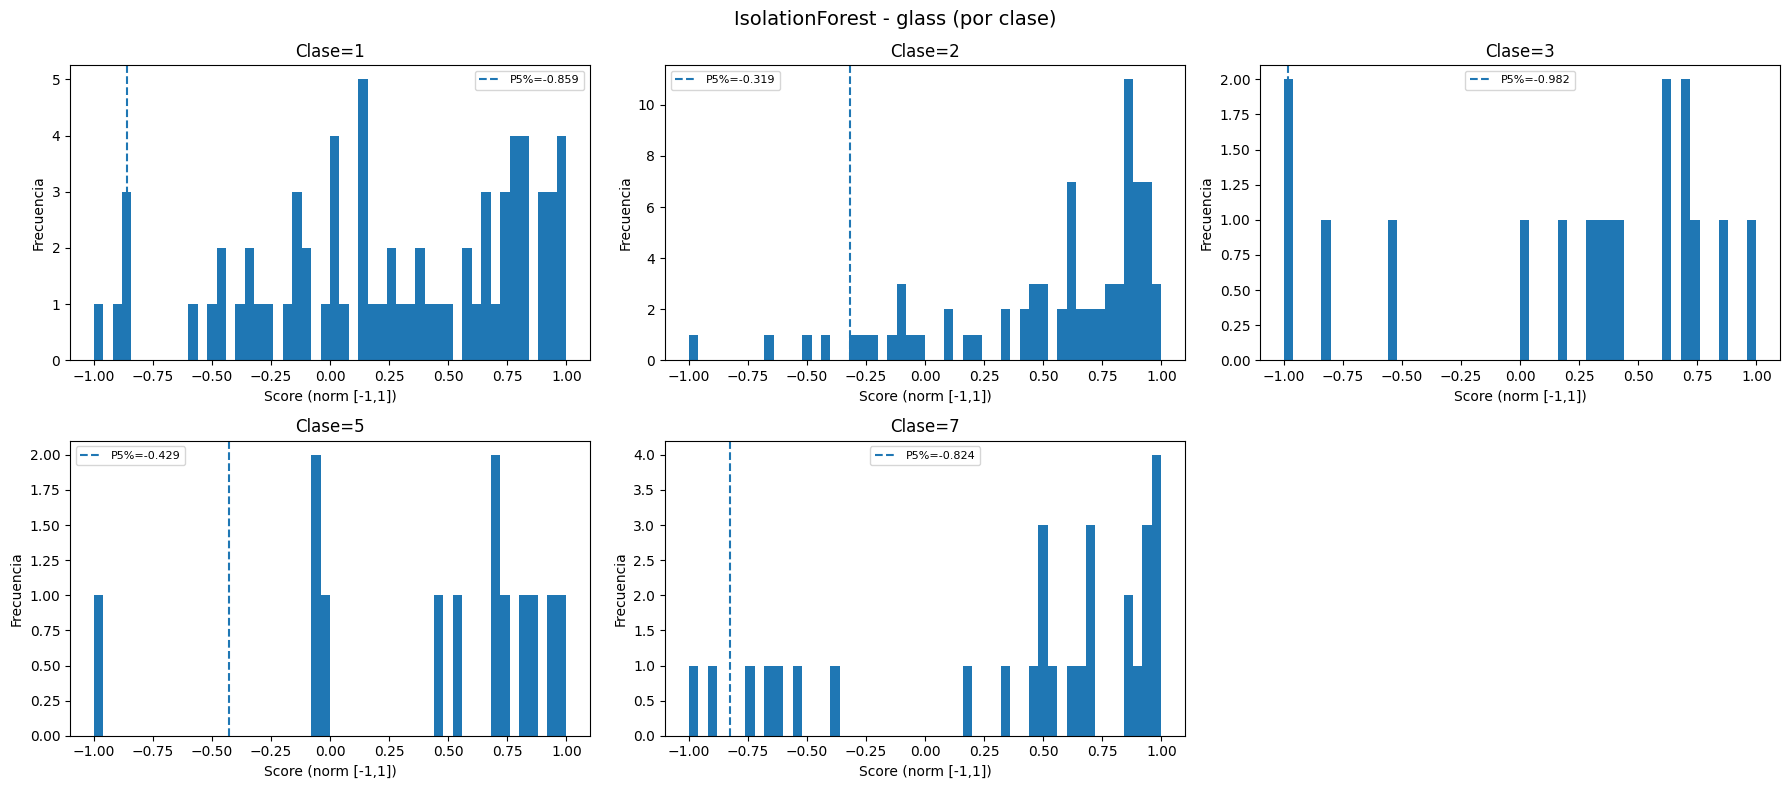


📈 Histogramas IF: HEART


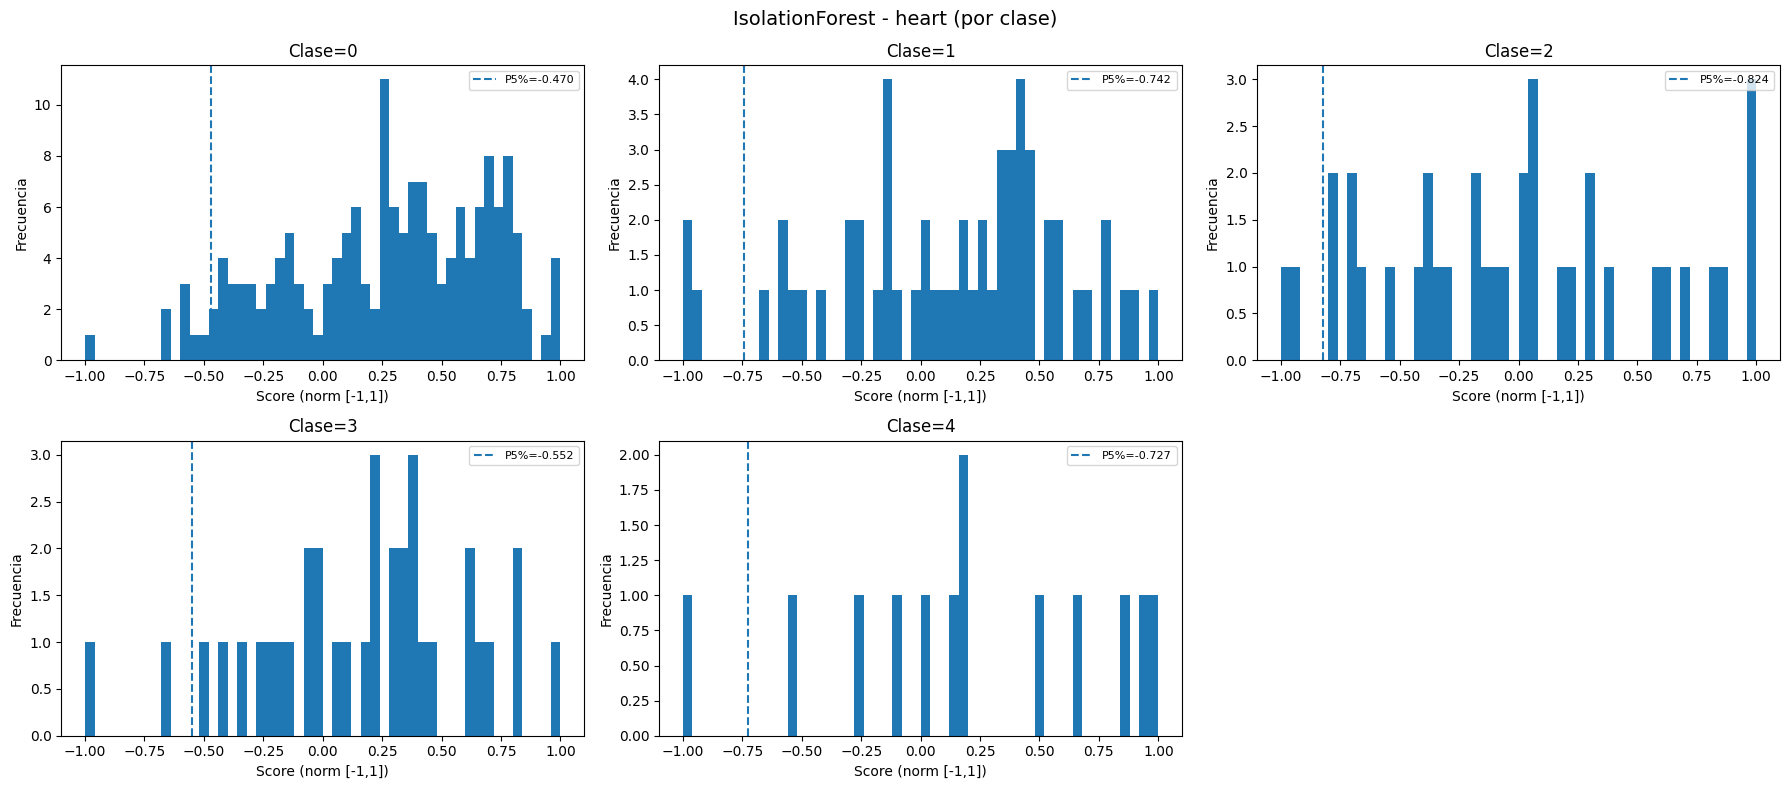


📈 Histogramas IF: IRIS


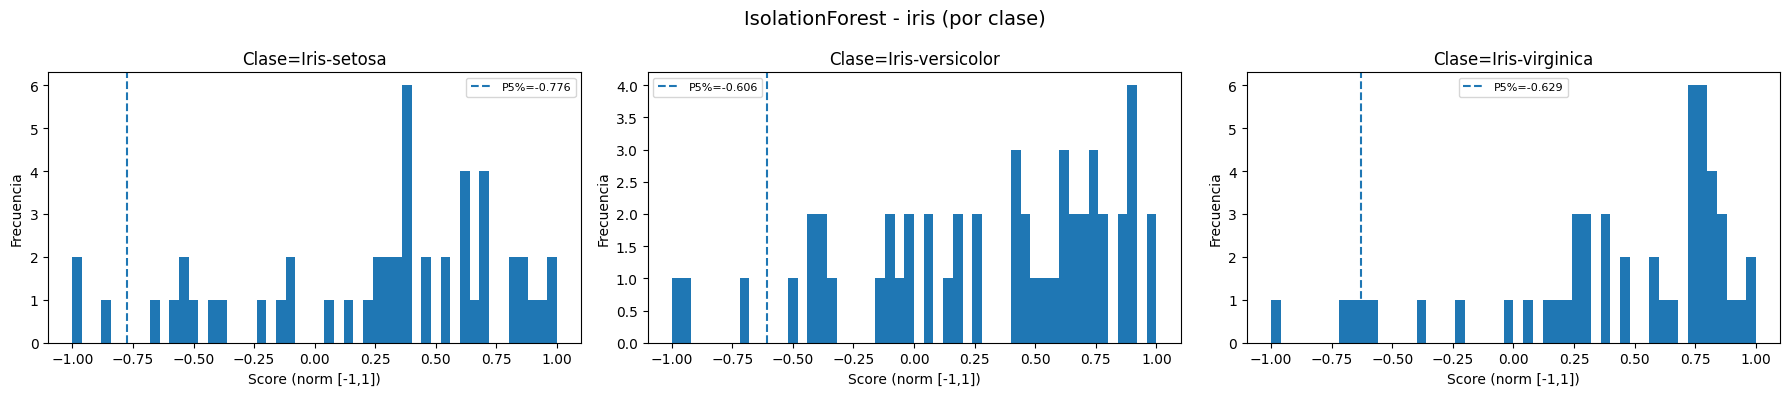


📈 Histogramas IF: ECOLI


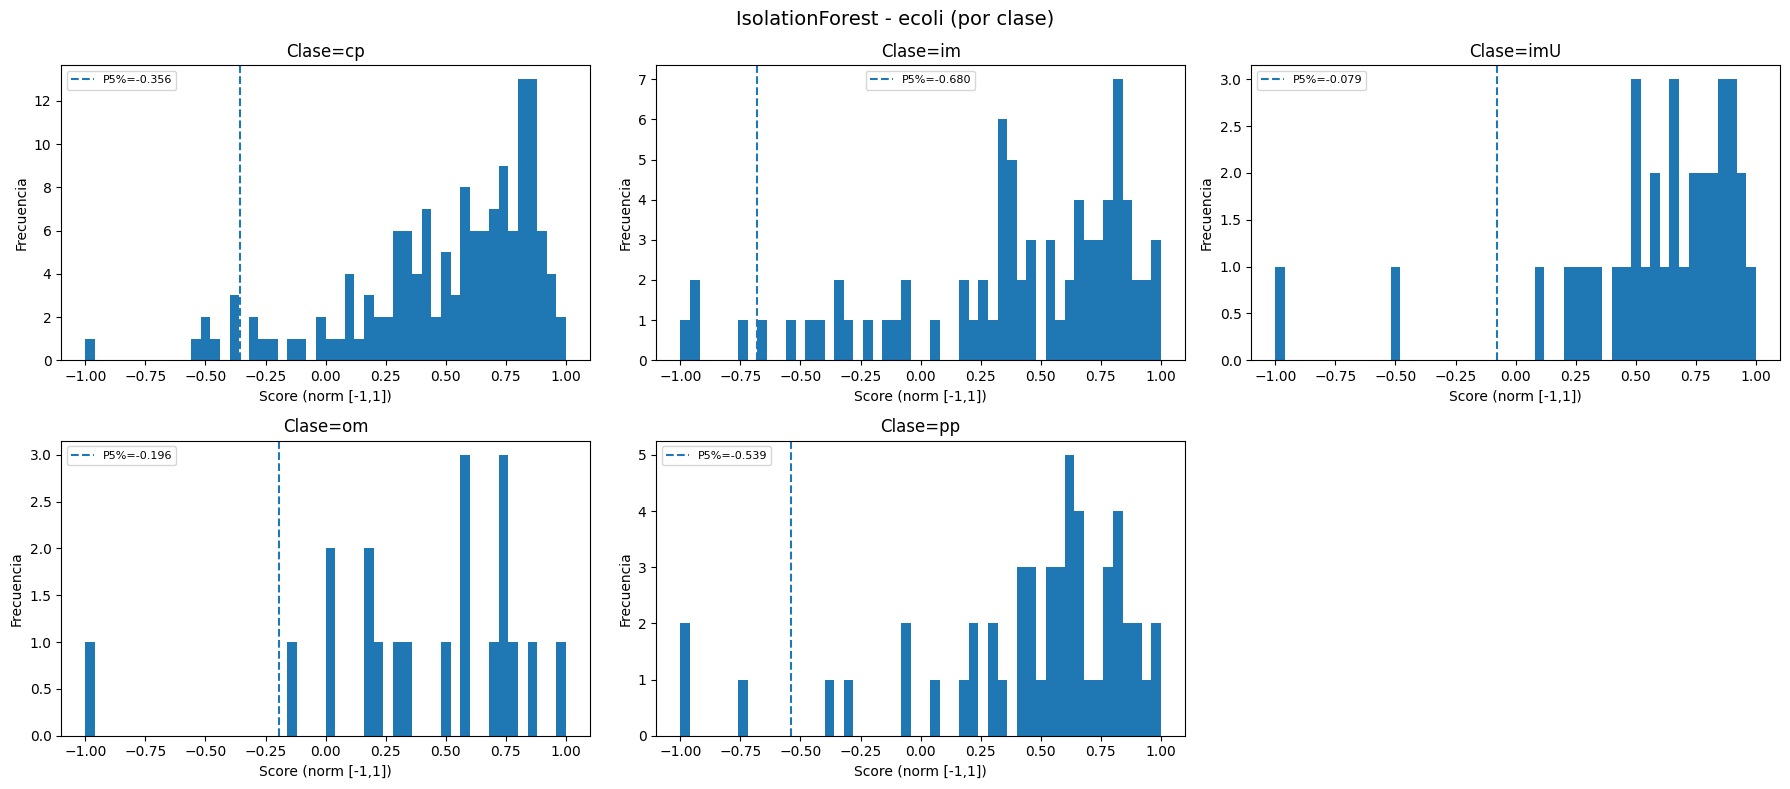


📝 Umbrales sugeridos guardados en: resultados_if/umbrales_if_2025-11-03_0018.txt
📄 Detalle (CSV) guardado en: resultados_if/umbrales_if_2025-11-03_0018.csv
🖼️ Figuras en carpeta: figuras_if/


In [1]:
# =========================
# HISTOGRAMAS DE SCORES IF
# =========================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from pathlib import Path
from datetime import datetime
from config_datasets import config_datasets
from cargar_dataset import cargar_dataset

# Parámetros generales del análisis de outliers
IF_PARAMS = dict(
    contamination="auto",
    n_estimators=200,
    max_samples="auto",
    random_state=42,
    bootstrap=False,
)

MODO = "por_clase"            # "por_clase" | "global"
NORMALIZAR_SCORES = True      # Normaliza scores a [-1, 1] por subset (global/clase)
PERCENTIL_OUTLIERS = 5        # Sugerencia: umbral por percentil (peores P% = outliers)
UMBRAL_FIJO = None            # p.ej. -0.6 si NORMALIZAR_SCORES=True; None = no usar

# Carpetas de salida
Path("figuras_if").mkdir(exist_ok=True)
Path("resultados_if").mkdir(exist_ok=True)

ts_if = datetime.now().strftime("%Y-%m-%d_%H%M")
path_txt = f"resultados_if/umbrales_if_{ts_if}.txt"
path_csv = f"resultados_if/umbrales_if_{ts_if}.csv"

registros = []   # para CSV
lineas = []      # para TXT

def _graficar_hist_bloque_por_clases(scores_por_clase: dict,
                                     nombre_dataset: str,
                                     fname: str,
                                     normalizado: bool,
                                     percentil: float,
                                     umbral_fijo):
    """
    Crea una única figura con N subplots (uno por clase) y guarda en fname.
    """
    clases = list(scores_por_clase.keys())
    n = len(clases)
    if n == 0:
        return

    # layout prolijo: hasta 3 columnas
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    # axes en array 2D o 1D según n; lo homogeneizamos
    axes = np.array(axes).reshape(-1)

    for i, c in enumerate(clases):
        ax = axes[i]
        scores = scores_por_clase[c]["scores_norm"]   # ya normalizados o no, según config
        thr_pct = scores_por_clase[c]["thr_pct"]
        ax.hist(scores, bins=50)
        ax.axvline(thr_pct, linestyle="--", label=f"P{percentil}%={thr_pct:.3f}")
        if umbral_fijo is not None:
            ax.axvline(umbral_fijo, linestyle="--", label=f"Fijo={umbral_fijo:.3f}")
        if not normalizado:
            ax.axvline(0.0, linestyle="--", label="0.0 (IF)")

        ax.set_title(f"Clase={c}")
        ax.set_xlabel("Score" + (" (norm [-1,1])" if normalizado else " (decision_function)"))
        ax.set_ylabel("Frecuencia")
        ax.legend(fontsize=8)

    # ocultar subplots vacíos si los hay
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"IsolationForest - {nombre_dataset} (por clase)", fontsize=14)
    fig.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.show()
    plt.close(fig)


def _normalizar_a_menos1_1(arr: np.ndarray) -> np.ndarray:
    a_min, a_max = np.min(arr), np.max(arr)
    if a_max > a_min:
        return 2.0 * (arr - a_min) / (a_max - a_min) - 1.0
    return np.zeros_like(arr)

def _scores_isolation_forest(Xsub: np.ndarray) -> np.ndarray:
    iforest = IsolationForest(**IF_PARAMS, n_jobs=1)
    iforest.fit(Xsub)
    s = iforest.decision_function(Xsub)  # >0 ~ inlier; <0 ~ outlier
    return s

def _umbral_por_percentil(scores: np.ndarray, p: float) -> float:
    # percentil "bajo": valores más negativos = más anómalos
    return np.percentile(scores, p)

def _graficar_hist(scores: np.ndarray, titulo: str, fname: str, cortes: list):
    plt.figure(figsize=(8, 5))
    plt.hist(scores, bins=50)  # no se especifican colores
    for c in cortes:
        if c is not None:
            plt.axvline(c, linestyle="--")
    plt.title(titulo)
    plt.xlabel("Score (decision_function)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

def _analizar_subset(scores: np.ndarray,
                     nombre_subset: str,
                     nombre_fig_base: str):
    # Normalización opcional
    s = _normalizar_a_menos1_1(scores) if NORMALIZAR_SCORES else scores

    # Umbrales sugeridos
    thr_pct = _umbral_por_percentil(s, PERCENTIL_OUTLIERS)
    thr_fijo = UMBRAL_FIJO

    # Graficar con líneas de corte
    cortes = [thr_pct, thr_fijo, 0.0 if not NORMALIZAR_SCORES else None]
    _graficar_hist(
        s,
        titulo=f"IF scores - {nombre_subset}",
        fname=f"{nombre_fig_base}.png",
        cortes=cortes
    )

    # Devolver dict con info
    return {
        "umbral_percentil": float(thr_pct),
        "umbral_fijo": float(thr_fijo) if thr_fijo is not None else None,
        "normalizado": NORMALIZAR_SCORES,
        "percentil": PERCENTIL_OUTLIERS,
    }

# =========
# EJECUCIÓN
# =========
for nombre, cfg in config_datasets.items():
    try:
        print(f"\n📈 Histogramas IF: {nombre.upper()}")
        X, y, clases = cargar_dataset(
            path=cfg["path"],
            clase_minoria=cfg.get("clase_minoria"),
            col_features=cfg.get("col_features"),
            col_target=cfg.get("col_target"),
            sep=cfg.get("sep", ','),
            header=cfg.get("header"),
            binarizar=cfg.get("binarizar", False),
            tipo=cfg.get("tipo", "tabular")
        )

        if MODO == "global":
            scores = _scores_isolation_forest(X)
            info = _analizar_subset(
                scores,
                nombre_subset=f"{nombre} (global)",
                nombre_fig_base=f"figuras_if/{nombre.lower()}_if_hist_global_{ts_if}"
            )
            lineas.append(f"[{nombre}] GLOBAL -> P{PERCENTIL_OUTLIERS}%={info['umbral_percentil']}"
                          + (f", UMB_FIJO={info['umbral_fijo']}" if info['umbral_fijo'] is not None else "")
                          + f", NORMALIZADO={info['normalizado']}")
            registros.append({
                "dataset": nombre,
                "modo": "global",
                "percentil": info["percentil"],
                "umbral_percentil": info["umbral_percentil"],
                "umbral_fijo": info["umbral_fijo"],
                "normalizado": info["normalizado"],
                "figura": f"{nombre.lower()}_if_hist_global_{ts_if}.png"
            })

        else:
            # =========================
            # BLOQUE ÚNICO POR DATASET
            # =========================
            clases_unicas = np.unique(y)

            scores_por_clase = {}  # {clase: {"scores_norm": ..., "thr_pct": ...}}
            figura_path = f"figuras_if/{nombre.lower()}_if_hist_por_clases_{ts_if}.png"

            for c in clases_unicas:
                idx = np.where(y == c)[0]
                if len(idx) < 10:
                    lineas.append(f"[{nombre}] clase={c} -> (<10 muestras) sin IF")
                    continue

                Xc = X[idx]
                s = _scores_isolation_forest(Xc)
                s_norm = _normalizar_a_menos1_1(s) if NORMALIZAR_SCORES else s

                thr_pct = _umbral_por_percentil(s_norm, PERCENTIL_OUTLIERS)
                scores_por_clase[c] = {
                    "scores_norm": s_norm,
                    "thr_pct": float(thr_pct)
                }

                # logging y CSV (una fila por clase)
                lineas.append(
                    f"[{nombre}] clase={c} -> P{PERCENTIL_OUTLIERS}%={thr_pct:.6f}"
                    + (f", UMB_FIJO={UMBRAL_FIJO}" if UMBRAL_FIJO is not None else "")
                    + f", NORMALIZADO={NORMALIZAR_SCORES}"
                )
                registros.append({
                    "dataset": nombre,
                    "modo": "por_clase",
                    "clase": c,
                    "percentil": PERCENTIL_OUTLIERS,
                    "umbral_percentil": float(thr_pct),
                    "umbral_fijo": float(UMBRAL_FIJO) if UMBRAL_FIJO is not None else None,
                    "normalizado": NORMALIZAR_SCORES,
                    "figura": f"{Path(figura_path).name}"
                })

            # generar una sola imagen con todos los histogramas por clase
            if len(scores_por_clase) > 0:
                _graficar_hist_bloque_por_clases(
                    scores_por_clase=scores_por_clase,
                    nombre_dataset=nombre,
                    fname=figura_path,
                    normalizado=NORMALIZAR_SCORES,
                    percentil=PERCENTIL_OUTLIERS,
                    umbral_fijo=UMBRAL_FIJO
                )


    except Exception as e:
        msg = f"❌ Error en histogramas IF para {nombre}: {e}"
        print(msg)
        lineas.append(msg)

# Guardar reporte de texto y CSV de umbrales
with open(path_txt, "w", encoding="utf-8") as f:
    f.write("\n".join(lineas))

df_reg = pd.DataFrame(registros)
df_reg.to_csv(path_csv, index=False, encoding="utf-8")

print(f"\n📝 Umbrales sugeridos guardados en: {path_txt}")
print(f"📄 Detalle (CSV) guardado en: {path_csv}")
print("🖼️ Figuras en carpeta: figuras_if/")


### Ahora toca estudiar cada dataset en cuanto a su composicion